In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(256,256),
    batch_size=(32)
)

Found 2152 files belonging to 3 classes.


bu metodun aldığı parametreler;
1. datasetin bulunduğu konum
2. shuffle, true veya false, böylece veriler karıştrılaca veya karıştırılmayacak
3. image_size(), olarak resimlerin boyutu verilir.
4. batch_size, adım sayısı gibi bir şey. 

batch boyutu , ağ üzerinden yayılacak numune sayısını tanımlar.

Örneğin, 1050 eğitim örneğiniz olduğunu ve batch_size100'e eşit bir değer ayarlamak istediğinizi varsayalım. Algoritma, eğitim veri kümesinden ilk 100 örneği (1'den 100'e kadar) alır ve ağı eğitir. Ardından, ikinci 100 örneği (101'den 200'e) alır ve ağı yeniden eğitir. Tüm örnekleri ağ üzerinden yayana kadar bu prosedürü yapmaya devam edebiliriz. Son numune setinde sorun olabilir. Örneğimizde, 100'e kalansız bölünemeyen 1050 kullandık. En basit çözüm, yalnızca son 50 örneği almak ve ağı eğitmektir.

Bu adım sonucunda 2152 veri ve 3 sınıf bulunduğunu söylüyor. 
Bu metodun amacı birden fazla veri dosyasını birleştirmek ve boyutlandırmak gibi bir işe yarıyor

In [4]:
data_class_names= dataset.class_names
data_class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

burada 68 yazmasının sebebi her bir veri kümesindeki öğe için 32 batch sayısını baz alarak, 32 görüntüden oluşan toplu bir işlem olarak alır.
68*32 yapıldığında bize 2176 olarak biraz daha fazlasını gösteriyor. 

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 1 2 2 0 1 2 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 2 0 1 1 1]


bakıldığında 32 resim olduğu, ve 256,256 boyutunda 3 boyutlu RGB resimlerdir. 
diğer 0,1,2  den oluşan ifadeler ise sınıfların kodlarıdır. 0-early, 1-late, 2-healty olarak.


In [7]:
for image_batch, label_batch in dataset.take(1):
#     1. print(image_batch[0])
    print(image_batch[0].numpy())

[[[187. 181. 185.]
  [183. 177. 181.]
  [180. 174. 178.]
  ...
  [183. 176. 183.]
  [186. 179. 186.]
  [190. 183. 190.]]

 [[193. 187. 191.]
  [188. 182. 186.]
  [185. 179. 183.]
  ...
  [188. 181. 188.]
  [184. 177. 184.]
  [180. 173. 180.]]

 [[196. 190. 194.]
  [193. 187. 191.]
  [191. 185. 189.]
  ...
  [183. 176. 183.]
  [179. 172. 179.]
  [178. 171. 178.]]

 ...

 [[155. 143. 147.]
  [141. 129. 133.]
  [133. 121. 125.]
  ...
  [126. 113. 120.]
  [120. 107. 114.]
  [117. 104. 111.]]

 [[149. 137. 141.]
  [139. 127. 131.]
  [137. 125. 129.]
  ...
  [129. 116. 123.]
  [125. 112. 119.]
  [124. 111. 118.]]

 [[132. 120. 124.]
  [136. 124. 128.]
  [149. 137. 141.]
  ...
  [140. 127. 134.]
  [137. 124. 131.]
  [138. 125. 132.]]]


Ayrıca başta bu şekildeki image_batch aslında bir tensor türünde veridir.
Bunu numpy a dönüştürdük. 

bundan sonra 3 boyutlu bir dizi ve tüm sayılar 0 ile 255 arasında bir değerde olarak görülüyor.


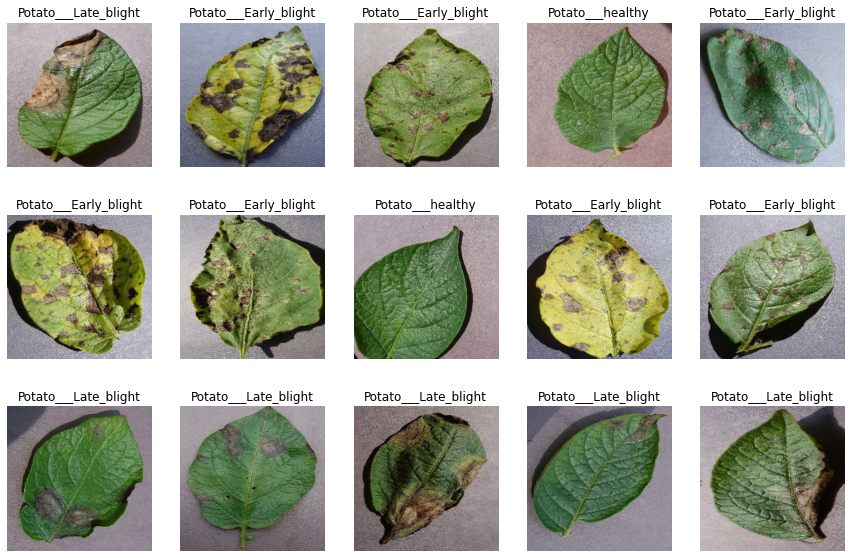

In [8]:
# veriyi görselleştirmek

# Bu satır olmazsa veriler karışık görüntülenir, aralık bırakarak seçkin görünmesi için
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15): 
# Bu satır olmazsa tek bir veriyi yazdırır
        ax= plt.subplot(3,5,i+1) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(data_class_names[label_batch[i]])
        plt.axis("off")

Bu görüntüleme işlemlerinden sonra veri setini bölüyoruz.

veri setini öncelikle %80 eğitim ve kalan %20  nin de %10 unu validation yani doğrulama, kalan %10 test verisi olarak ayrılacak.


80% ==> training
20% ==> 10% validation, 10% test

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

eğitim verisi olarak datasetin yani bulunan 68 değerinin yüzde 80 nini bulduk yani 54 e yakın. Bu değeri take() metoduyla alarak train_dataset olarak atadık. 

In [10]:
train_dataset= dataset.take(54)
len(train_dataset)

54

In [11]:
tests_dataset= dataset.skip(54)
len(tests_dataset)

14

In [12]:
val_size=0.1 
len(dataset)*val_size

6.800000000000001

In [13]:
val_dataset= tests_dataset.take(6)
tests_dataset= tests_dataset.skip(6)
print(len(val_dataset))
print(len(tests_dataset))

6
8


ardından kalan veri yani 14'ü validation ve test olarak almamız gerektiğinden öncelikle datasetin yüzde 1' inin karşılığını bulduktan sonra bu değeri val_dataset olarak ve aynı şekilde yüzde 1 olarak kalan test verisini de bu şekilde hesaplamayla aldık.

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000): 
    ds_size= len(ds)
    
    if shuffle: 
        ds=ds.shuffle(shuffle_size,seed=12)
#seed sadece tahmin edilebilirlik için yani aynı verileri vermemek için kullanılır.

    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)
    val_size= int(val_split*ds_size)
#kesirli ifadeler çıkmaması için int olarak alındı

    train_data= ds.take(train_size)
    val_data= ds.skip(train_size).take(val_size)
    test_data= ds.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data

bölme işlemlerini daha fonksiyonel şekilde yapmak için yukarıdaki metod kullanılır.

In [15]:
train_data, val_data, test_data= get_dataset_partitions_tf(dataset)

In [16]:
len(train_data)

54

In [17]:
len(val_data)

6

In [18]:
len(test_data)

8

üstte yapılan bütün bölme işlemleri fonksiyonla yapılarak aynı sonuçlar alındı.

In [19]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

cache(), ile önbelleğe alacağız. görüntüyü diskten alacak ve daha sonra aynı görüntüye ihtiyaç olduğunda bu görüntüyü bellekte tutacak.

prefetch, GPU,CPU dan bilinir. GPU şuan eğitimde meşgulse, prefetch diskinizden bir sonraki kümeyi diskten yükleyecektir. bu da performansı arttırır. 



##### Ön işleme için katman oluşturma

In [20]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Yukarıda ön işleme yapılıyor.

ilk adım olarak bir resize yaparak görüntüyü 256*256 olarak yeniden boyutlandırılacak.

yukarıda verilen experimental özelliği kullanılarak yapılıyor. 
Bu özelliğin stabil,kararlı olduğu söyleniyor. 
Bu işlemle görüntü 255 e ölçeklendirilecek.

yani eğitim sırasında farklı boyutta resimler gelirse yukarıdaki komut bunu yeniden şekillendirerek istenilen boyutlara getirecektir. 


Ön işlemede yapılacak bir diğer önemli şey ise veriyi çoğaltmadır. 
görüntülerle model eğitildikten sonra döndürülmüş veya farklı kontrastta veri verildiğinde doğru sınıflandırma yapmayı öğrenememiş olacak bu açıdan veri büyütme (data augmentation) işlemi yapılır. 



In [21]:
data_augementation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
# rastgele döndürmeler yaparak farklılaştırıldı

oluşturulan bu ön işleme katmanları orjinal modelde kullanılacak.

Modeli oluşturma

In [22]:
n_classes=3
model= models.Sequential([
    resize_and_rescale, # ilk katman yeniden boyutladırılacak
    # bir görüntü eklendiğinde ilk şey yeniden boyutlandırma olacak
    data_augementation, # ardından veri büyütülecek.
    # döndürme ve kontrast ayarları yapılarak data augmentation gerçekleştirilir.
    layers.Conv2D(32, kernel_size=(3,3), activation ="relu", input_shape=(32,256,256,3)),
    # üçüncü katman convulation katmanı. 
    
    # ilk parametre filters, ikinci kernel-size,
    # kernel-size temel anlamda filtrenin boyutudur. 
    # üçüncü aktivasyon katmanı
    # dördüncü input size 
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation ="relu"),
    layers.MaxPooling2D((2,2)),
    
    # 4. katman Flatter (düzleştirme katmanı)
    
    layers.Flatten(),
    
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation ="softmax"), 
])
model.build((32,256,256,3))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [25]:
history = model.fit(
    train_data,
    epochs= 50,
    batch_size=32,
    verbose=1,
    validation_data= val_data
)

Epoch 1/50
54/54 [==============================] - 36s 647ms/step - loss: 0.9170 - accuracy: 0.4763 - val_loss: 0.8980 - val_accuracy: 0.4271
Epoch 2/50
54/54 [==============================] - 36s 661ms/step - loss: 0.7740 - accuracy: 0.6076 - val_loss: 0.7425 - val_accuracy: 0.7240
Epoch 3/50
54/54 [==============================] - 35s 653ms/step - loss: 0.4926 - accuracy: 0.7911 - val_loss: 0.3546 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 35s 658ms/step - loss: 0.3747 - accuracy: 0.8519 - val_loss: 0.4391 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 34s 636ms/step - loss: 0.3311 - accuracy: 0.8669 - val_loss: 0.3237 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 35s 654ms/step - loss: 0.2783 - accuracy: 0.8964 - val_loss: 0.2746 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 35s 645ms/step - loss: 0.2203 - accuracy: 0.9161 - val_loss: 0.2864 - val_accuracy: 0.8750

In [26]:
#modeli test etmek
scores= model.evaluate(test_data)
# modelin önyargılı olmaması için eldeki verilerle test ediyoruz.

8/8 [==============================] - 2s 142ms/step - loss: 0.0373 - accuracy: 0.9883


##### Modelin başarısı %97 doğruluk seviyesinde 

In [27]:
scores

[0.0373472236096859, 0.98828125]

ilk parametre kayıp, başarısızlık yüzdesidir.


ikinci parametre ise başarım oranıdır.

In [28]:
#history olarak oluşturduğumuz değişken, terasın callbaks history'si olarak gösterilir.
history

In [29]:
history.params
#{'verbose': 1, 'epochs': 50, 'steps': 54}

history.history.keys()
#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])
#list

len(history.history['loss'])
#50

50

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9170276522636414,
 0.7739906907081604,
 0.49257582426071167,
 0.37465783953666687,
 0.33110299706459045]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

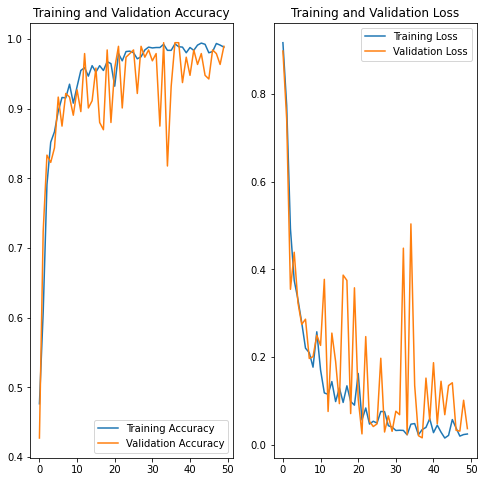

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Run prediction on a sample image

class_names = dataset.class_names
class_names

first image to predict
first image's actual label: Potato___Early_blight
predicted label:  Potato___Early_blight


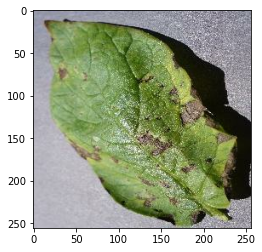

In [44]:
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", data_class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print("predicted label: ", data_class_names[np.argmax(batch_prediction[0])])

# üç sınıfa ayırdığımız için  3 olasılık olarak çıkar sonuç hangisi yüksekse o sınıf içerisinde kabul ederiz.
    

##### Write a function for inference

In [139]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = data_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

##### run inference on few sample images

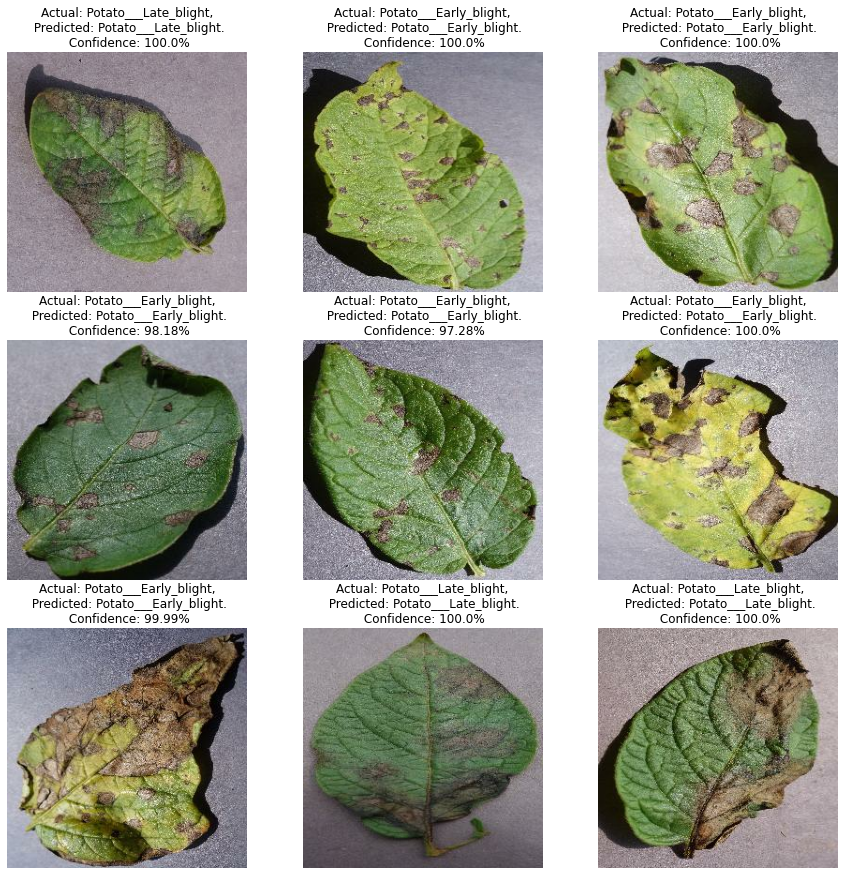

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model

In [41]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


In [43]:
model.save("potatoes.h5")